In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *

import pandas as pd

p = Project.objects.get(pk=341)

q, created = Query.objects.get_or_create(
    title="Climate and Health: y < 2022",
    project=p
)

dids = set(Doc.objects.filter(query=q).values_list('pk', flat=True))
len(dids)

Multicore TSNE not installed, tsne maps will not be able to be calculated
Gensim not installed, you will need this for running Doc2Vec models


960273

In [2]:
regenerate_docinfo = False
if regenerate_docinfo:
    df = pd.DataFrame.from_dict(Doc.objects.filter(pk__in=dids).values('id','PY','title','content','wosarticle__dt'))
    df.columns = ["id","Publication Year","Title","Abstract","Document type"]
    df.head()
    df.to_csv('data/0c_doc_info.csv',index=False)

In [3]:

django.db.connection.close()

dos = DocOwnership.objects.filter(tag__query__project=p, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

# Get relevant / not relevant decisions
do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = np.NaN
do_df.head()

# Get category assignment
cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")

df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'category__name',
        'category__level',
        'user__username',
        'selection_tier'
    )
).drop_duplicates(["doc__id","category__name","user__username"])
# Filter so that it matches the relevant set
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]

# Rename category to capture level
df['category__level'] = df['category__level'].astype(str)
df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
#df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)

# Capture the primary/secondary value (1 for primary, 2 for secondary)
df['val'] = df['selection_tier']

df.head()


,doc__id,doc__title,doc__content,category__name,category__level,user__username,selection_tier,Category Name,val
0,4825235,Inactivation of avian influenza virus by heat ...,Avian influenza viruses threaten the life of d...,2.03. Climate sensitivity,4,alessandra.landa@outlook.it,1,4 - 2.03. Climate sensitivity,1
1,100896,Severe Flooding and Malaria Transmission in th...,Background. There are several mechanisms by wh...,4.01. Floods and drought,5,alessandra.landa@outlook.it,1,5 - 4.01. Floods and drought,1
2,4825235,Inactivation of avian influenza virus by heat ...,Avian influenza viruses threaten the life of d...,2.05. Infectious diseases,3,alessandra.landa@outlook.it,1,3 - 2.05. Infectious diseases,1
3,4951588,Comparison of health outcomes from heat-relate...,It is predicted that heat waves will increase ...,2.03. Climate sensitivity,4,alessandra.landa@outlook.it,1,4 - 2.03. Climate sensitivity,1
4,3245360,Characterizing the role of socioeconomic pathw...,Urban dwellers worldwide are increasingly affe...,2.05. Scenarios,4,alessandra.landa@outlook.it,1,4 - 2.05. Scenarios,1


In [4]:
# Merge relevant/not relevant with categories
do_df['Category Name'] = "0 - relevant"

merged_df = pd.concat([
    df[['doc__id','doc__title','doc__content','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
])

cats = merged_df['Category Name'].unique()
merged_df.tail()

,doc__id,doc__title,doc__content,user__username,Category Name,val
4393,586326,Necrotizing fasciitis due to Vibrio cholerae n...,We report on two cases of necrotizing fasciiti...,galm,0 - relevant,1.0
4394,3401314,Recovery from post-traumatic stress disorder a...,Background: Victims exposed to serious traumat...,galm,0 - relevant,1.0
4395,3823015,"Principles, drivers, and policy tools for just...",Climate change adaptation presents an opportun...,galm,0 - relevant,0.0
4396,28127,The Direct Impact of Climate Change on Regiona...,Global climate change will increase outdoor an...,galm,0 - relevant,1.0
4397,3448921,"Forecasting incidence of hand, foot and mouth ...","Background Hand, foot and mouth disease (HFMD)...",galm,0 - relevant,1.0


In [5]:
cats.sort()
cats

array(['0 - relevant', '2 - 1.01. CO2 rise',
       '2 - 1.02. Changes in temperature', '2 - 1.03. Seasonal change',
       '2 - 1.04. Changes in precipitation', '2 - 1.05. Sea-level rise',
       '2 - 1.06. Climate change (unspecified)',
       '2 - 1.07. Other meteorological variables',
       '3 - 2.01. Food security', '3 - 2.02. Mental health and sentiment',
       '3 - 2.03. Cardiorespiratory disease',
       '3 - 2.04. Direct injury and death',
       '3 - 2.05. Infectious diseases', '3 - 2.06. Other health impacts',
       '3 - 2.07. Water security', '3 - 2.08. Mortality and morbidity',
       '3 - 2.09. Health system capacity',
       '4 - 2.01. Climate change attribution',
       '4 - 2.02. Trend attribution', '4 - 2.03. Climate sensitivity',
       '4 - 2.04. Extreme event attribution', '4 - 2.05. Scenarios',
       '5 - 4.01. Floods and drought', '5 - 4.02. Heatwaves',
       '5 - 4.03. Wildfires', '5 - 4.04. Other extreme events',
       '5 - 4.05. Extreme cold', '6 - 5.01.

In [6]:
# fill tag values with 0s where they have been rated
dudf_wide = (merged_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
include_policy_columns = [x for x in policy_columns if "not policy related" not in x.lower() and "broader" not in x.lower()]
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
#dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN

dudf_wide.to_csv('data/0_all_labels.csv',index=False)

dudf_wide.tail()

Category Name,doc__id,doc__title,doc__content,user__username,0 - relevant,2 - 1.01. CO2 rise,2 - 1.02. Changes in temperature,2 - 1.03. Seasonal change,2 - 1.04. Changes in precipitation,2 - 1.05. Sea-level rise,...,4 - 2.05. Scenarios,5 - 4.01. Floods and drought,5 - 4.02. Heatwaves,5 - 4.03. Wildfires,5 - 4.04. Other extreme events,5 - 4.05. Extreme cold,6 - 5.01. Pollution,"6 - 5.02. Biodiversity loss, ecosystem & microbial change",6 - 5.03. Reduced agricultural & aquaculture productivity,6 - 5.04. Reduced labour and physical capacity
4361,5173318,Assessment of highly polluted fluvisol in the ...,"Background, Goal and Scope. Nearly all large E...",alessandra.landa@outlook.it,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4362,5177085,Productivity and physiological response of stu...,The influence of luminance level on students' ...,alessandra.landa@outlook.it,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4363,5177085,Productivity and physiological response of stu...,The influence of luminance level on students' ...,ari.avallone@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4364,5178523,Isolated abducens nerve palsy following mandib...,"Spinal, general, and epidural anesthesia have ...",alessandra.landa@outlook.it,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4365,5178523,Isolated abducens nerve palsy following mandib...,"Spinal, general, and epidural anesthesia have ...",ari.avallone@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dudf_wide.columns

Index(['doc__id', 'doc__title', 'doc__content', 'user__username',
       '0 - relevant', '2 - 1.01. CO2 rise',
       '2 - 1.02. Changes in temperature', '2 - 1.03. Seasonal change',
       '2 - 1.04. Changes in precipitation', '2 - 1.05. Sea-level rise',
       '2 - 1.06. Climate change (unspecified)',
       '2 - 1.07. Other meteorological variables', '3 - 2.01. Food security',
       '3 - 2.02. Mental health and sentiment',
       '3 - 2.03. Cardiorespiratory disease',
       '3 - 2.04. Direct injury and death', '3 - 2.05. Infectious diseases',
       '3 - 2.06. Other health impacts', '3 - 2.07. Water security',
       '3 - 2.08. Mortality and morbidity', '3 - 2.09. Health system capacity',
       '4 - 2.01. Climate change attribution', '4 - 2.02. Trend attribution',
       '4 - 2.03. Climate sensitivity', '4 - 2.04. Extreme event attribution',
       '4 - 2.05. Scenarios', '5 - 4.01. Floods and drought',
       '5 - 4.02. Heatwaves', '5 - 4.03. Wildfires',
       '5 - 4.04. Other e

In [8]:
# Now get a single value for each document by choosing the most common selection
import statistics
def resolve_conflicts(x):
    valid_codes = np.array([y for y in x if pd.notna(y)])
    rounded_codes = np.floor(valid_codes+0.5)
    l = len(set(valid_codes))
    if l==0: # If no valid codes return NA
        return np.NaN, np.NaN
    w = 1 # Sample weight for training - can be reduced by up to a 3rd of maximum by each following condition
    w -= (np.std(rounded_codes) * 2) / 3 # Reduce weight by the amount of substantive disagreement (between 1 and 0)
    w -= (valid_codes==0.5).sum()/valid_codes.shape[0] / 3 # reduce weight by the percentage of labels which were secondary
    rm = np.mean(rounded_codes)
    if rm > 0.5: # overall, a majority coded positive (primary or secondary)
        return 1, w
    elif rm==0.5: # even split, can't decide
        return np.NaN, w
    else: 
        return 0, w
    
# First make it long, so that each row is a doc-category-user rating
xdf = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','user__username'])

xdf['value'] = xdf['value'].replace(2,0.5)

# Now group by doc and category, and resolve conflicts
resolved_long = xdf.groupby(['doc__id','doc__title','doc__content','Category Name'])['value'].count().reset_index()
resolved_long['value'], resolved_long['sample_weight'] = zip(*
                                                        xdf.groupby(['doc__id','doc__title','doc__content','Category Name'])['value']
                                                        .agg(lambda x: resolve_conflicts(x))
                                                      )



# Now pivot so that each category is a column
seen_df = resolved_long.drop(columns="sample_weight").pivot(index=["doc__id","doc__title","doc__content"],columns="Category Name").reset_index()
weights_df = resolved_long
weights_df["Category Name"] = weights_df["Category Name"] + "_sample_weight"
weights_df = weights_df.drop(columns="value").pivot(index=["doc__id","doc__title","doc__content"],columns="Category Name").reset_index()
weights_df.columns = [col[1] if col[1] !="" else col[0] for col in weights_df.columns]
weights_df.to_csv('data/0_label_weights.csv',index=False)
print(seen_df.shape)

seen_df.columns = [col[1] if col[1] !="" else col[0] for col in seen_df.columns]

print(seen_df[pd.isna(seen_df['0 - relevant'])].shape)

seen_df.head()

cols_4 = [x for x in seen_df.columns if re.match("^4 -",x)]
seen_df[seen_df['doc__id']==1828017][["doc__id"]+cols_4]

(1950, 34)
(177, 34)


,doc__id,4 - 2.01. Climate change attribution,4 - 2.02. Trend attribution,4 - 2.03. Climate sensitivity,4 - 2.04. Extreme event attribution,4 - 2.05. Scenarios


0 - relevant
-1.0     177
 0.0    1149
 1.0     624
dtype: int64

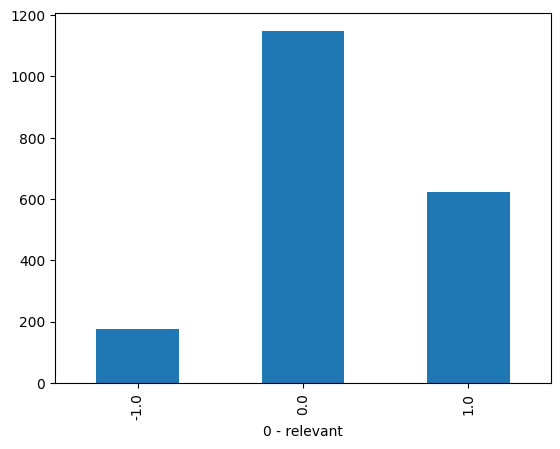

In [9]:
import matplotlib.pyplot as plt

seen_df.fillna(-1).groupby('0 - relevant').size().plot.bar()
seen_df.fillna(-1).groupby('0 - relevant').size()

In [10]:
(resolved_long
 .groupby('sample_weight')['doc__id']
 .count()
 .sort_values(ascending=False)
 .head())

sample_weight
1.000000    44196
0.666667     1295
0.685730     1173
0.574619       38
0.888889       33
Name: doc__id, dtype: int64

In [11]:
cats = list(seen_df.columns)
cats.sort()
cats

['0 - relevant',
 '2 - 1.01. CO2 rise',
 '2 - 1.02. Changes in temperature',
 '2 - 1.03. Seasonal change',
 '2 - 1.04. Changes in precipitation',
 '2 - 1.05. Sea-level rise',
 '2 - 1.06. Climate change (unspecified)',
 '2 - 1.07. Other meteorological variables',
 '3 - 2.01. Food security',
 '3 - 2.02. Mental health and sentiment',
 '3 - 2.03. Cardiorespiratory disease',
 '3 - 2.04. Direct injury and death',
 '3 - 2.05. Infectious diseases',
 '3 - 2.06. Other health impacts',
 '3 - 2.07. Water security',
 '3 - 2.08. Mortality and morbidity',
 '3 - 2.09. Health system capacity',
 '4 - 2.01. Climate change attribution',
 '4 - 2.02. Trend attribution',
 '4 - 2.03. Climate sensitivity',
 '4 - 2.04. Extreme event attribution',
 '4 - 2.05. Scenarios',
 '5 - 4.01. Floods and drought',
 '5 - 4.02. Heatwaves',
 '5 - 4.03. Wildfires',
 '5 - 4.04. Other extreme events',
 '5 - 4.05. Extreme cold',
 '6 - 5.01. Pollution',
 '6 - 5.02. Biodiversity loss, ecosystem & microbial change',
 '6 - 5.03. Redu

In [12]:
# Loop through the comparison/resolution files and resolve labelled dataset
resolutions = pd.DataFrame()

cat_resolver = {
    "3 – 2.08. Mortality and morbidity": "3 - 2.08. Mortality and morbidity",
    "4 – 2.05. Scenarios": '4 - 2.05. Scenarios',
    "6 – 5.01. Pollution": '6 - 5.01. Pollution',
    "5.01. Pollution": '6 - 5.01. Pollution',
    "3 – 2.09. Health system capacity": '3 - 2.09. Health system capacity',
    "3 - 2.05. Infectious Diseases": '3 - 2.05. Infectious diseases',
    "2 - 1.02. Temperature rise": '2 - 1.02. Changes in temperature',
    "4 - 2.03 climate sensitivity": '4 - 2.03. Climate sensitivity',
}

for fname in os.listdir("decision_resolutions"):
    if ".xlsx" in fname:
        try:
            cdf = pd.read_excel(f'decision_resolutions/{fname}',sheet_name="comparison")
        except:
            print(f"Cannot read {fname}")
    dcolumn = [x for x in cdf.columns if "decision" in x.lower()][0]
    cdf = cdf.rename(columns={dcolumn: "decision"})
    cdf = cdf[pd.notna(cdf["decision"])]
    cdf = cdf[cdf['Category Name'].str.match("^[0-9]{1}(?![1-2])")]
    
    cdf['fname'] = fname
    
    resolutions = pd.concat([resolutions, cdf])
    
    for i, row in cdf.iterrows():
        try:
            x = int(row["decision"])
        except:
            print(f"could not parse {row['decision']}")
            continue
        cname = row['Category Name']   
        if cname not in seen_df.columns:
            cname = cat_resolver[cname]
        seen_df.loc[(seen_df['doc__id']==row['doc__id']),cname] = row["decision"]
        
print(resolutions.shape)
resolutions.to_csv('data/0_conflict_resolutions.csv',index=False)

(2622, 15)


In [13]:


# corrections = pd.read_csv('decision_resolutions/master/corrections.csv', quotechar="'")

# for i, row in corrections.iterrows():
#     try:
#         x = int(row[dcolumn])
#     except:
#         print(f"could not parse {row[dcolumn]}")
#         continue
#     cname = row['Category Name']

#     for r1, r2 in renamings:
#         cname = cname.replace(r1,r2)
#     if cname not in seen_df.columns:
#         matches = [x for x in seen_df.columns if cname.split('. ')[1] in x]
#         if len(matches) == 1:
#             cname = matches[0]
#         else:
#             print(cname)
#             continue

#     seen_df.loc[(seen_df['doc__id']==row['doc__id']),cname] = row[dcolumn]


In [14]:
list(Tag.objects.filter(query__project=p).values_list('title'))

[('all',),
 ('all',),
 ('all',),
 ('Review refs 1',),
 ('Food refs 2',),
 ('Food refs 1',),
 ('Food set 2',),
 ('Food set 1',),
 ('Test set 8',),
 ('Random Test set 3',),
 ('Test set 7',),
 ('Random Test set 2',),
 ('Random Test set 1',),
 ('Test set 6',),
 ('Test set 5',),
 ('Test set 4',),
 ('Test set 3',),
 ('Test set 2',),
 ('Test set 1',)]

In [15]:
# Tag whether the document is part of a representative sample
django.db.connection.close()
seen_df["representative_sample"] = 0
random_tags = Tag.objects.filter(query__project=p, title__icontains="Random")
random_ids = set(DocOwnership.objects.filter(tag__in=random_tags, relevant__gt=0).values_list('doc__id',flat=True))
seen_df.loc[seen_df['doc__id'].isin(random_ids),"representative_sample"] = 1

In [16]:
seen_df['representative_relevant'] = 1
kw_tags = Tag.objects.filter(query__project=p, title__icontains="keyword")
kw_ids = set(DocOwnership.objects.filter(tag__in=kw_tags, relevant__gt=0).values_list('doc__id',flat=True))
seen_df.loc[seen_df['doc__id'].isin(kw_ids),"representative_relevant"] = 0

/tmp/ipykernel_98498/1643552218.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in seen_df.groupby(['representative_sample']):


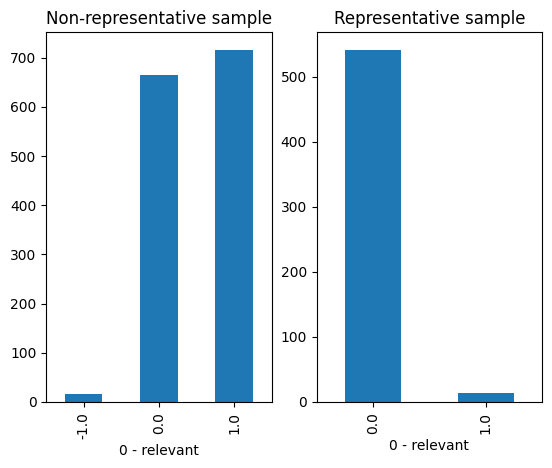

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
labels = ["Non-representative sample","Representative sample"]
for name, group in seen_df.groupby(['representative_sample']):
    ax = axs[name]
    ax.set_title(labels[name])
    group.groupby('0 - relevant').size().plot.bar(ax=ax)

In [18]:
seen_df[seen_df['representative_sample']==1]['0 - relevant'].sum()

13.0

In [19]:
seen_df.rename(
    columns={"doc__id":"id","doc__content":"content","doc__title":"title"}
).to_csv('data/0_labelled_documents.csv',index=False)

In [20]:
rewrite_unseen = True

if rewrite_unseen:

    columns = [
        'id',
        'content',
        'title',
        'wosarticle__de',
        'wosarticle__wc'
    ]

    unseen_docs = Doc.objects.filter(
        id__in=dids,
        content__iregex='\w',
    ).exclude(pk__in=seen_df['doc__id'])

    unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
    unseen_df = unseen_df[columns]
    unseen_df['relevant'] = 0
    unseen_df['seen'] = 0
    unseen_df['random'] = 0

    print(unseen_df.shape)
    unseen_df.to_feather('data/0_unlabelled_documents.feather')
    unseen_df.head()

(925751, 8)


In [21]:
seen_df.columns


Index(['doc__id', 'doc__title', 'doc__content', '0 - relevant',
       '2 - 1.01. CO2 rise', '2 - 1.02. Changes in temperature',
       '2 - 1.03. Seasonal change', '2 - 1.04. Changes in precipitation',
       '2 - 1.05. Sea-level rise', '2 - 1.06. Climate change (unspecified)',
       '2 - 1.07. Other meteorological variables', '3 - 2.01. Food security',
       '3 - 2.02. Mental health and sentiment',
       '3 - 2.03. Cardiorespiratory disease',
       '3 - 2.04. Direct injury and death', '3 - 2.05. Infectious diseases',
       '3 - 2.06. Other health impacts', '3 - 2.07. Water security',
       '3 - 2.08. Mortality and morbidity', '3 - 2.09. Health system capacity',
       '4 - 2.01. Climate change attribution', '4 - 2.02. Trend attribution',
       '4 - 2.03. Climate sensitivity', '4 - 2.04. Extreme event attribution',
       '4 - 2.05. Scenarios', '5 - 4.01. Floods and drought',
       '5 - 4.02. Heatwaves', '5 - 4.03. Wildfires',
       '5 - 4.04. Other extreme events', '5 - 4.05